# Time series analysis in the MTA turnstile data


## Introduction

The main objective of this work is to analyze MTA turnstile data in order to find outliers, trends and periodicity in it.

In [20]:
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image
%matplotlib inline

In [2]:
#download data
url = 'https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy'
os.system('wget ' + url)
os.system("mv " + 'MTA_Fare.npy ' + os.getenv("PUIDATA"))


0

In [3]:
#load rawData
rawData = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')
print rawData.shape

(600, 23, 194)


Our data set consist in ridership records of 600 subway stations, for 23 card types across 194 weeks from 05/21/2010 to 02/21/2014.

In [4]:
#change nas
data = np.where(rawData == -1, np.nan, rawData)

# Part I - Identifying the most prominent event in the series for all the stations and card types


Our main objetive here is to see if in the whole series there are some prominent events. For that purpose, we get the average across all stations and for all the card types. The result is a time series wich representes the overall activity in the subway lines for NYC.

In [5]:
stationsMean = np.nanmean(data,axis=0)
allMeans = np.nanmean(stationsMean,axis=0)
allMeans.shape

/home/pipe/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(194,)

In [6]:
#weeks 05/21/2010 to 02/21/2014.
import datetime

start = datetime.datetime.strptime("05/21/2010","%m/%d/%Y")
end = datetime.datetime.strptime("02/21/2014", "%m/%d/%Y")
weeks = []
base = start
for i in range(194):
    weeks.append(base)
    base = base + datetime.timedelta(days=7)
weeks = np.array(weeks)



In [7]:
rng = pd.date_range('05/21/2010',periods = 194, freq = 'w')

To detect this unusual events in ridership, first we must set a threshold beyond which we consider that event interesting enough. A first visual inspection of data shows a week where ridership as an important drop. Therefore, we'll stablish a threshold of 3 times the standar deviation of the ridership.

In [9]:
threshold = allMeans.mean() - 3 * allMeans.std()

''

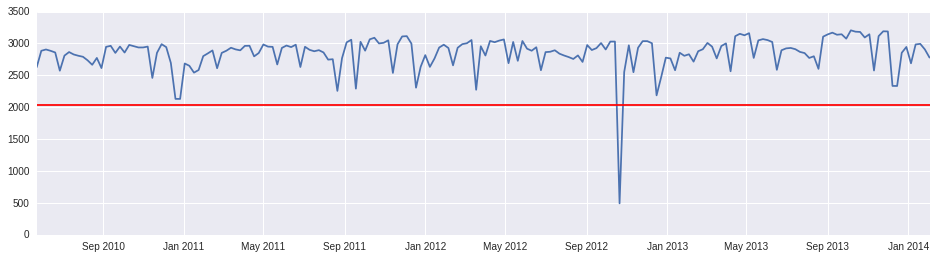

In [12]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.plot(rng,allMeans)
ax.plot((rng[0], rng[193]), (threshold, threshold), 'r-')
ax.set_title('Ridership from May 2010 to February 2014')
ax.set_xlabel('Week')
ax.set_ylabel('Ridership from May 2010 to February 2014')
''

### Figure 1
The plot shows the ridership for every line and every card type, throughout 194 weeks. As we can see, ridership fluctuates around 2500 and 3000 trips per week, with one exception. During one week, it drops to only 500 rides, crossing the stablished threshold (2000 rides). This is the only moment in the series that something like that occurs. 

In [25]:
print' The event was around the week of %s' % (str(rng[np.where(allMeans<threshold)[0][0]]))[:10]

 The event was around the week of 2012-10-21


For what we could learn about that week, one event appears to be the more meaningful

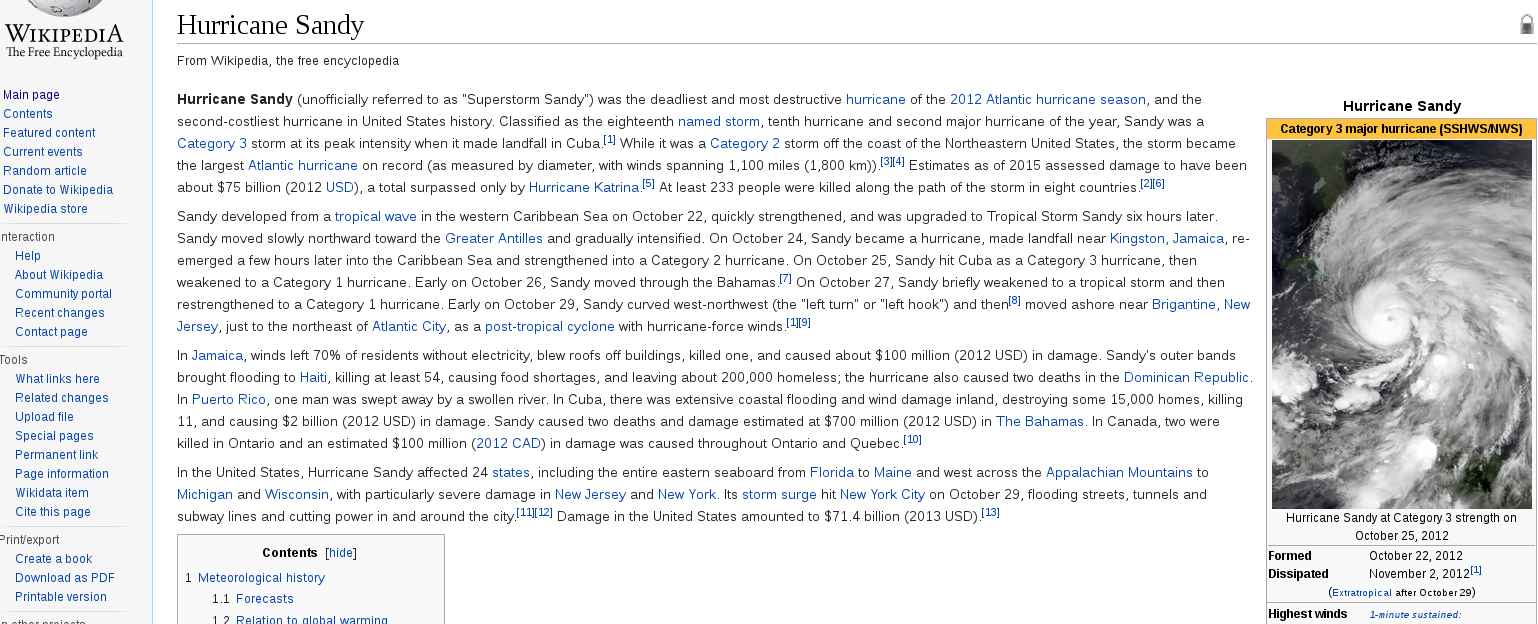

In [24]:
Image('img/sandy.png')


### Figure 2
The Wikipedia article for the Hurricane Sandy, showing that it happened during the last week of October. 

# Part II - Identifying the ridership types that have steadily increased in popularity, and that have steadily decreased. 

Another goal could be to examin every card type to see its usage during this period of time. This would allow to see increasing or decreasing popularity in types of cards. Based on this information, different policies could be enacted: from removing a specific type of card due to low usage, to change the price of a trip for a car type based on an increasing popularity that could endanger the bussines model.

To analyse this, we compound the average across all subway stations and we get a dataset for all the 23 card types and their ridership throughout the 194 weeks.

In [26]:
riderMean = np.nanmean(data,axis=0)
riderMean.shape

(23, 194)

In [55]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

Then we define a function that can get the rolling mean over 10 week for every card type's timeseries, and then:
* Plot the series with a line fitted through the series to see if there is a tendency.  
* Print the slope of the line
* Print the correlation coefficients (the magnitude of the coefficients will serve as a proxy of the tendency strength and the sign will indicate if that tendency is an increasing or a decreasing one)  
* Print the flux ratio from beginning to end of the series. In consistently increasing tendencies, beginning will be smaller, so for strong tendencies the ratio will be smaller, and the opposite for consistently decreasing tendencies.

In [77]:
def getSlope(riderMeanID):
    #take the rolling mean over 10 week
    series = pd.Series(riderMean[riderMeanID]).rolling(10).mean()

    Y = series
    xAxis = series.index
    X = sm.add_constant(xAxis)
    model = sm.OLS(Y,X,missing = 'drop').fit()
    #flux ratio and other metrics
    print 'Flux ratio beginning to end ', Y[0:10].mean() / Y[-10:].mean()
    print 'Slope %s: %.2f' %(ridetype[riderMeanID],model.params[1]) 
    print 'Correlation %s: %.2f' %(ridetype[riderMeanID],np.corrcoef(xAxis[9:],Y[9:])[0,1] * 100) 

    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    ax.plot(rng,series)
    ax.plot([rng[0],rng[193]],[model.params[0],model.params[0] + 193*model.params[1]],'r-')
    
    ax.set_title('Ridership from May 2010 to February 2014 for %s card' % (ridetype[riderMeanID]))
    ax.set_xlabel('Week')
    ax.set_ylabel('Ridership')

    


With this function, we can visualize inspect each of the 23 card types (in a line: *[getSlope(x) for x in range(23)]*) . Nevertheless, we'll show only those with the strongest tendencies.   

Flux ratio beginning to end  0.379006117373
Slope rr: 1.34
Correlation rr: 98.33


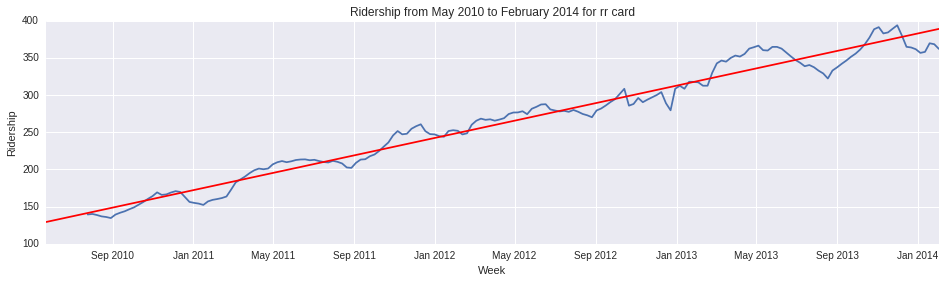

In [78]:
getSlope(15)

### Figure 3
The plot shows ridership for the rail road card across almost 194 (as we use the rolling mean for 10 weeks we can't get values for the first 9 weeks). A line is fitted through the data, showing the consistently increasing tendency. Also, the aforementioned metrics are printed. This increase in railroad could be due to changes in price (which would increase demand) or changes in commute pattterns due to more people living in the suburbs of the city and commuting more frequently through rail road instead of subway. Yet, this is just an hypothesis that remains to be tested.

Flux ratio beginning to end  0.340117304501
Slope sen: 0.73
Correlation sen: 98.26


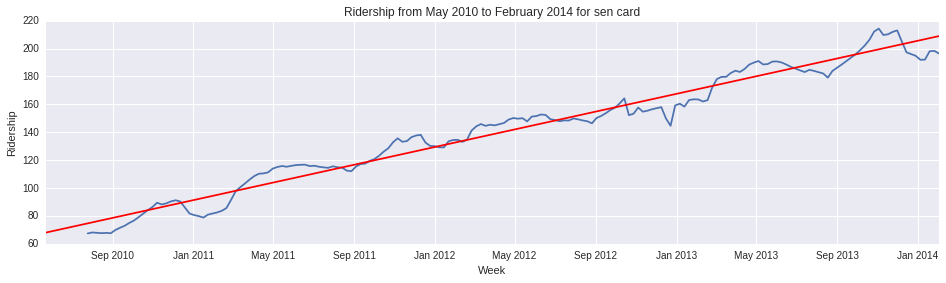

In [79]:
getSlope(16)

### Figure 4
The plot shows ridership for the senior citicen card across almost 194. The fitted line also shows the consistently increasing tendency. In this case, the increase of ridership in senior citizen cards could be to a change of price, an increase in communication campaigns for senior citizen that made this option more known on the target population. 

Flux ratio beginning to end  1.66060714147
Slope month: -0.64
Correlation month: -93.55


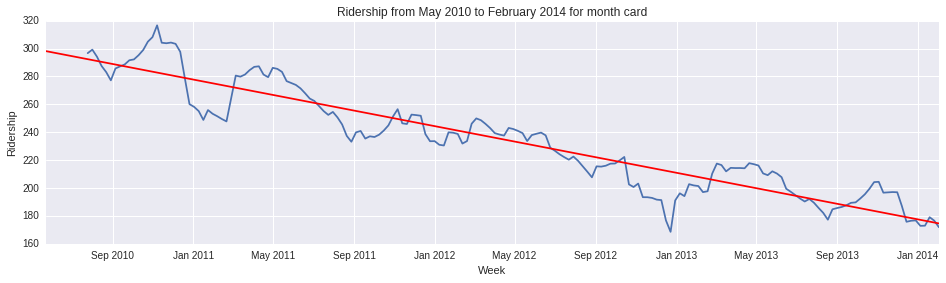

In [80]:
getSlope(13)

### Figure 5
As the plot shows, the timeseries with the strongest consistently decreasing tendency is the one for the monthly card. Fitted line and metrics shows this also. Maybe in a context of income difficulties, spending decisions are being made in shorter time frames. Under this assumption people would rather opt for a cheapest individual ticket by buying them in bulk through the 7 days or 14 days card, instead of the monthly one. We can see that 7 and 14 day cards are increasing in ridership. 

Flux ratio beginning to end  0.685668124714
Slope 7d: 23.43
Correlation 7d: 91.26


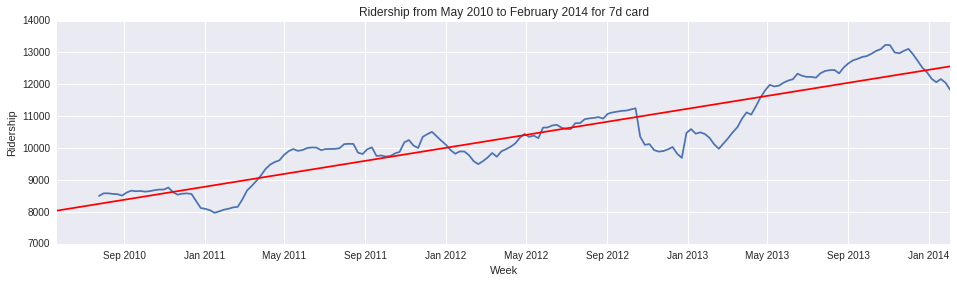

In [87]:
getSlope(5)

Flux ratio beginning to end  0.752755892908
Slope 14d: 2.46
Correlation 14d: 91.15


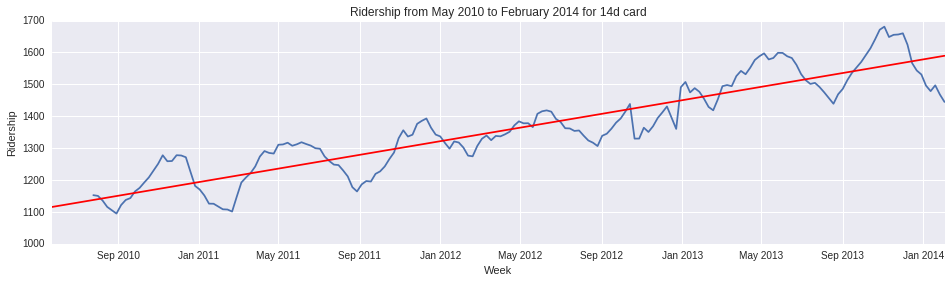

In [88]:
getSlope(1)

### Figures 6 and 7
Plots showing ridership increase over time on 7 and 14 day cards.


# Part III - Subway stations with annual periodicity

In [49]:
stationsMean = np.nanmean(data,axis=1)

In [94]:
#frequency of the 
stationsMean.shape

(600, 194)

We have a dataset that for each of the 600 stations has the average ridership across all card types over 194 weeks. We need to know, for a Fourier transformation, which element of the resulting frequency corresponds to the annual cycle that we are interested in (52 weeks). The function np.fft.rfftfreq(N, d) gives the frequency in a 1/week type of format. So we need to convert this into weeks.

In [96]:
1 / np.fft.rfftfreq(194, 1.0)

array([          inf,  194.        ,   97.        ,   64.66666667,
         48.5       ,   38.8       ,   32.33333333,   27.71428571,
         24.25      ,   21.55555556,   19.4       ,   17.63636364,
         16.16666667,   14.92307692,   13.85714286,   12.93333333,
         12.125     ,   11.41176471,   10.77777778,   10.21052632,
          9.7       ,    9.23809524,    8.81818182,    8.43478261,
          8.08333333,    7.76      ,    7.46153846,    7.18518519,
          6.92857143,    6.68965517,    6.46666667,    6.25806452,
          6.0625    ,    5.87878788,    5.70588235,    5.54285714,
          5.38888889,    5.24324324,    5.10526316,    4.97435897,
          4.85      ,    4.73170732,    4.61904762,    4.51162791,
          4.40909091,    4.31111111,    4.2173913 ,    4.12765957,
          4.04166667,    3.95918367,    3.88      ,    3.80392157,
          3.73076923,    3.66037736,    3.59259259,    3.52727273,
          3.46428571,    3.40350877,    3.34482759,    3.28813

As we can see, the 4th element is the one closest to the annual cycle we are interested in. Therefore, we need to find wich lines has the highest spectrum power for that cycle. 

In [128]:
def getSpectrum(stationId):
    f = np.abs(np.fft.rfft(stationsMean[stationId]))[4]
    return f


In [129]:
stationsSpectrum = pd.Series()
[stationsSpectrum.set_value(i, getSpectrum(i)) for i in range(stationsMean.shape[0])]

[0               NaN
 1               NaN
 2        909.333322
 3       3383.070590
 4       1815.397225
 5       2636.697318
 6        877.095265
 7       2402.550907
 8       1564.447833
 9      18938.084883
 10     20687.308397
 11     21395.181595
 12      9223.232807
 13     39732.216291
 14              NaN
 15      2672.692973
 16     12435.117451
 17     42525.481025
 18      8315.998200
 19     49395.717951
 20     26909.081440
 21     12097.523387
 22     28255.176280
 23     14298.250974
 24      8559.708167
 25              NaN
 26     27310.059118
 27     35408.301328
 28     35703.146412
 29     10553.899375
            ...     
 570             NaN
 571             NaN
 572             NaN
 573             NaN
 574             NaN
 575             NaN
 576             NaN
 577             NaN
 578             NaN
 579             NaN
 580             NaN
 581             NaN
 582             NaN
 583             NaN
 584             NaN
 585             NaN
 586         

In [189]:
annualCycleStations = stationsSpectrum.sort_values(ascending=False)[:4]
annualCycleStations.index

Int64Index([194, 150, 32, 327], dtype='int64')

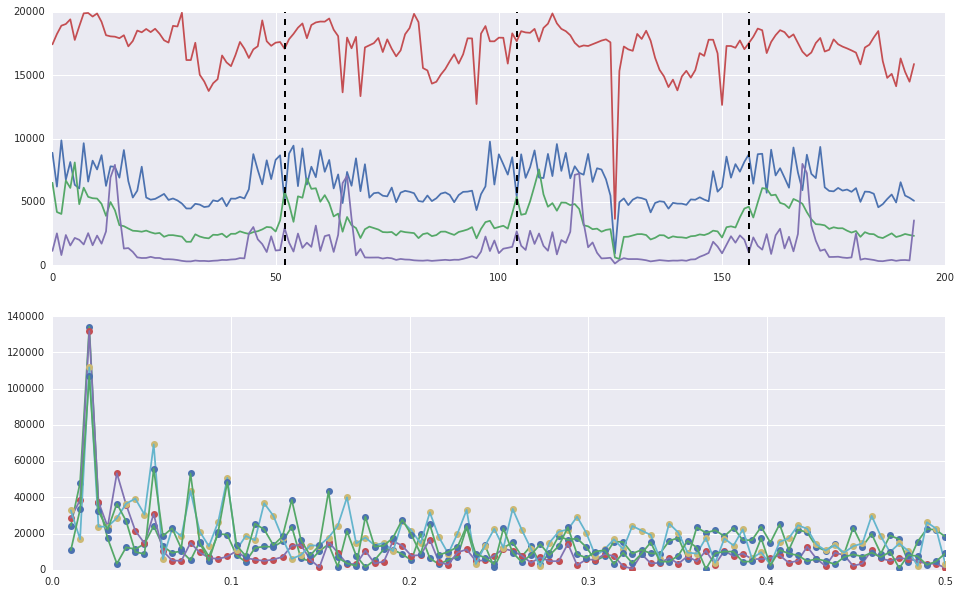

In [154]:
fig=plt.figure(figsize=(16,10))
    
for plotId in [1,2]:
    ax = fig.add_subplot(2,1,plotId)
    for i in annualCycleStations.index:
        if(plotId == 1):
            ax.plot(stationsMean[i])
            ax.plot([52,52],[0,20000],'k--')
            ax.plot([104,104],[0,20000],'k--')
            ax.plot([156,156],[0,20000],'k--')
        else:
            f = np.abs(np.fft.rfft(stationsMean[i]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[2:], (f[2:]), 'o')
            ax.plot(np.fft.rfftfreq(194, 1.0)[2:], (f[2:]), '-')
            

In [187]:
rng[p1]

Timestamp('2010-12-12 00:00:00', offset='W-SUN')

In [188]:
rng[p2]

Timestamp('2010-07-18 00:00:00', offset='W-SUN')

In [260]:
def plotPeek(stationID):
    fig=plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(rng,stationsMean[stationID])
    p1 = np.where(stationsMean[stationID]== max(stationsMean[stationID][:52]))[0]
    ax.plot([rng[p1],rng[p1]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+52],rng[p1+52]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+(52*2)],rng[p1+(52*2)]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+(52*3)],rng[p1+(52*3)]],[0,max(stationsMean[stationID])],'g--')
    print rng[p1]

DatetimeIndex(['2010-06-06'], dtype='datetime64[ns]', freq=None)


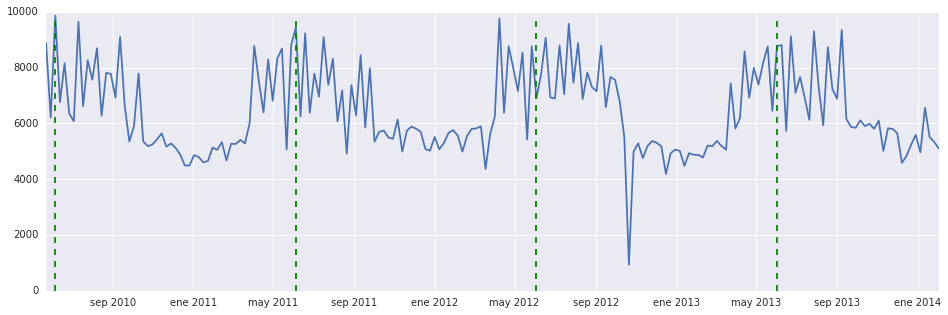

In [261]:
#194, 150, 32, 327
plotPeek(194)

DatetimeIndex(['2010-06-27'], dtype='datetime64[ns]', freq=None)


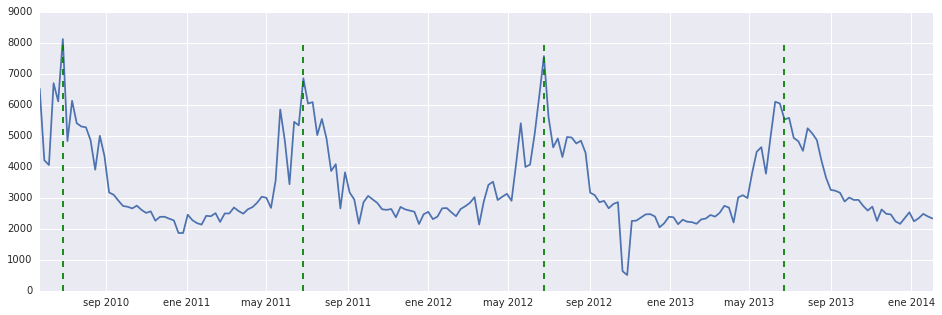

In [262]:
#194, 150, 32, 327
plotPeek(150)

DatetimeIndex(['2010-08-29'], dtype='datetime64[ns]', freq=None)


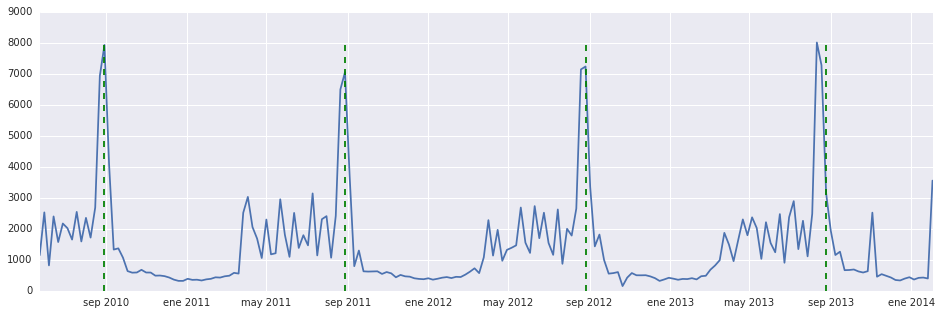

In [263]:
#194, 150, 32, 327
plotPeek(327)

DatetimeIndex(['2010-12-12'], dtype='datetime64[ns]', freq=None)


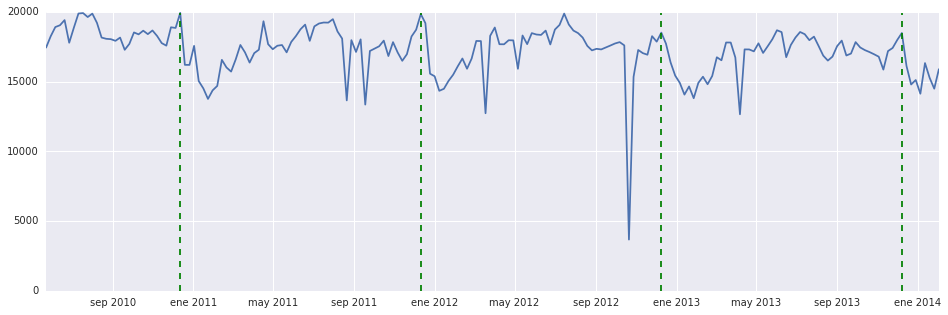

In [264]:
#194, 150, 32, 327
plotPeek(32)

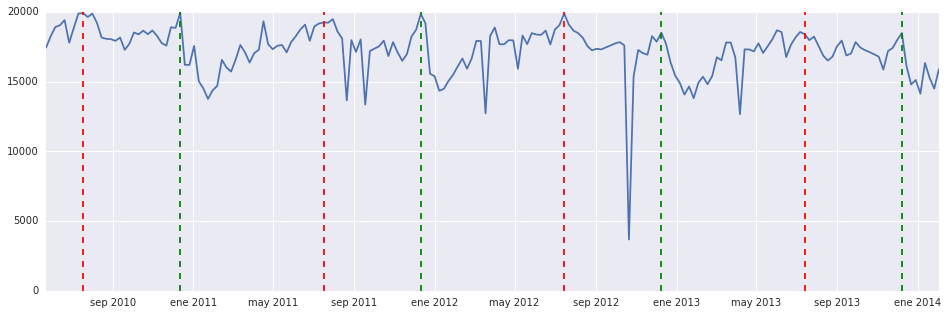

In [265]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
ax.plot(rng,stationsMean[32])
p1 = 29
p2 = 8
ax.plot([rng[p1],rng[29]],[0,20000],'g--')
ax.plot([rng[p1+52],rng[p1+52]],[0,20000],'g--')
ax.plot([rng[p1+(52*2)],rng[p1+(52*2)]],[0,20000],'g--')
ax.plot([rng[p1+(52*3)],rng[p1+(52*3)]],[0,20000],'g--')

ax.plot([rng[p2],rng[p2]],[0,20000],'r--')
ax.plot([rng[p2+52],rng[p2+52]],[0,20000],'r--')
ax.plot([rng[p2+(52*2)],rng[p2+(52*2)]],[0,20000],'r--')
ax.plot([rng[p2+(52*3)],rng[p2+(52*3)]],[0,20000],'r--')


In [266]:
print rng[p1]

2010-12-12 00:00:00


In [267]:
print rng[p2]

2010-07-18 00:00:00
